# Predictive Maintenance of Turbofan Jet Engine: Remaining Useful Life Regression

Here we will be evaluating a few models for the regression of remaining useful life. The results will be compared to the baseline model below:
- RMSE against Test Set: 22.3685
- MAE against Test Set: 17.8900

Once we have choose the best model, we will further evaluate it on the test set and compare with the given true RUL.

## 1. Load FD001 Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_dataset, calculate_RUL

In [2]:
train, test, test_rul = read_dataset("FD001")
train.shape, test.shape, test_rul.shape

((20631, 26), (13096, 26), (100,))

## 2. Build Pipeline

In [3]:
from sklearn.pipeline import Pipeline
from utils import (SENSOR_COLUMNS, LowVarianceFeaturesRemover, ScalePerEngine, RollTimeSeries, TSFreshFeaturesExtractor, CustomPCA, TSFreshFeaturesSelector, tsfresh_calc)

preprocessing = Pipeline([
    ('drop-low-variance', LowVarianceFeaturesRemover(threshold=0)),
    ('scale-per-engine', ScalePerEngine(n_first_cycles=10, sensors_columns=SENSOR_COLUMNS)),
    ('roll-time-series', RollTimeSeries(min_timeshift=19, max_timeshift=19, rolling_direction=1)),
    ('extract-tsfresh-features', TSFreshFeaturesExtractor(calc=tsfresh_calc)),
    ('PCA', CustomPCA(n_components=20)),
    ('features-selection', TSFreshFeaturesSelector(fdr_level=0.001))
])

In [4]:
train = preprocessing.fit_transform(train)

Dropped features: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Start Rolling TS


Rolling: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Done Rolling TS in 0:00:09.924466
Start Extracting Features


Feature Extraction: 100%|██████████| 20/20 [06:59<00:00, 20.96s/it]


Done Extracting Features in 0:07:27.730287
Dropped 19 duplicate features
Dropped 14 features with NA values
Selected 10 out of 20 features: [0, 2, 3, 4, 1, 5, 6, 8, 7, 15]


In [5]:
train.index = train.index.set_names(['unit', 'time_cycles'])
print('train shape after pipeline:', train.shape)
train.head()

train shape after pipeline: (17731, 10)


0         2         3         4         1         5   \
unit time_cycles                                                                
1.0  30.0         -9.621386 -1.371975  5.191464  0.054828 -1.199549  0.844392   
     31.0         -9.606291 -1.232110  5.135508  0.179561 -1.077269  2.018672   
     32.0        -10.308093 -1.298788  5.198759 -1.302478 -0.891965  1.396961   
     33.0        -10.131534 -0.869859  5.472415 -0.976122 -0.968814  0.938607   
     34.0         -9.200284 -1.104652  4.923388 -0.435127 -0.761176  0.046133   

                        6         8         7         15  
unit time_cycles                                          
1.0  30.0        -0.590629 -2.036566  3.959777 -1.407563  
     31.0        -0.816393 -2.107204  2.911140 -1.635141  
     32.0         0.043931 -2.375148  2.345193 -2.681971  
     33.0         0.085886 -3.012547  3.961745 -2.582504  
     34.0        -0.009720 -4.006164  4.296591 -2.074314

## 3. Split features and target

In [6]:
X_train = train.reset_index().drop(columns=['unit'])

train_units_df = train.index.to_frame(index=False)
y_train = calculate_RUL(train_units_df, upper_threshold=135)

## 4. Linear Regression

First, let's train a Linear Regression model to evaluate whether all those preprocessing steps actually helps to achieve better performance than our baseline model which is a Linear Regression model without any preprocessing.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

from utils import CustomGroupKFold, evaluate

In [8]:
lin_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lin_reg_cv = evaluate(
    lin_reg,
    X=X_train.values,
    y=y_train,
    groups=train_units_df['unit'],
    cv=CustomGroupKFold(n_splits=5),
)

[test] :: root mean squared error : 15.62 +- 0.96
[train] :: root mean squared error : 15.47 +- 0.25
[test] :: mean absolute error : 12.61 +- 0.69
[train] :: mean absolute error : 12.43 +- 0.21


We can see that just by implementing our preprocessing pipeline, we were able to improve the performance of Linear Regression model as compared to the baseline model.

## 5. SVM (Support Vector Machines)

Since we know that our preprocessing pipeline worked, let's train a SVM model and see if it's better than Linear Regression

In [9]:
from sklearn.svm import SVR

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

svm_cv = evaluate(
    svm,
    X=X_train.values,
    y=y_train,
    groups=train_units_df['unit'],
    cv=CustomGroupKFold(n_splits=5),
)

[test] :: root mean squared error : 15.82 +- 1.08
[train] :: root mean squared error : 14.54 +- 0.14
[test] :: mean absolute error : 12.23 +- 0.80
[train] :: mean absolute error : 10.71 +- 0.13


Nothing significant when comparing SVM result to Linear Regression. 

## 6. Decision Tree

In [10]:
from sklearn.tree import DecisionTreeRegressor

dt = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

dt_cv = evaluate(
    dt,
    X=X_train.values,
    y=y_train,
    groups=train_units_df['unit'],
    cv=CustomGroupKFold(n_splits=5),
)

[test] :: root mean squared error : 19.45 +- 0.68
[train] :: root mean squared error : 0.00 +- 0.00
[test] :: mean absolute error : 14.97 +- 0.61
[train] :: mean absolute error : 0.00 +- 0.00


Seems like our Decision Tree model is very overfitted and it performs badly during cross-validation.

## 7. Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

rf_cv = evaluate(
    rf,
    X=X_train.values,
    y=y_train,
    groups=train_units_df['unit'],
    cv=CustomGroupKFold(n_splits=5),
)

[test] :: root mean squared error : 14.26 +- 0.63
[train] :: root mean squared error : 2.74 +- 0.05
[test] :: mean absolute error : 10.99 +- 0.42
[train] :: mean absolute error : 1.81 +- 0.03


Our random forest model is overfitted similar to decision tree. However, it is performing better in cross-validation when compared to SVM and Linear Regression.

## 8. XGBoost

In [12]:
from xgboost import XGBRegressor

xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor())
])

xgb_cv = evaluate(
    xgb,
    X=X_train.values,
    y=y_train,
    groups=train_units_df['unit'],
    cv=CustomGroupKFold(n_splits=5),
)

[test] :: root mean squared error : 14.55 +- 0.41
[train] :: root mean squared error : 4.79 +- 0.13
[test] :: mean absolute error : 11.12 +- 0.25
[train] :: mean absolute error : 3.37 +- 0.08


Our XGBoost model is also overfitted. Although XGBoost and Random Forest is performing better than Linear Regression / SVM in cross-validation, we want a model that can generalizes well to new data. For predictive maintenance setting, we would have many operation modes, thus more data and new patterns to learn.

As of right now, Linear Regression or SVM is still the best model in our opinion.

## 9. NGBoost

NGBoost stands for Natural Gradient Boosting and it is used for probabilistic prediction. This model is very interesting for us because the biggest problem of single point predictions is that it provides **no uncertainty estimates** of a given prediction.

Thus, we would like to focus on methods that are above to provide **prediction intervals**. One of it is NGBoost that outputs a full probability distribution over the entire outcome space.

In [13]:
from ngboost import NGBRegressor
from ngboost.distns import Poisson

In [14]:
ngb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', NGBRegressor(Dist=Poisson))
])

ngb_cv = evaluate(
    ngb,
    X=X_train.values,
    y=y_train,
    groups=train_units_df['unit'],
    cv=CustomGroupKFold(n_splits=5),
)

[iter 0] loss=17.6044 val_loss=0.0000 scale=2.0000 norm=0.9514
[iter 100] loss=5.0638 val_loss=0.0000 scale=2.0000 norm=0.4187
[iter 200] loss=4.3844 val_loss=0.0000 scale=1.0000 norm=0.1767
[iter 300] loss=4.2607 val_loss=0.0000 scale=1.0000 norm=0.1706
[iter 400] loss=4.2061 val_loss=0.0000 scale=1.0000 norm=0.1678
[iter 0] loss=17.6165 val_loss=0.0000 scale=2.0000 norm=0.9521
[iter 100] loss=5.1596 val_loss=0.0000 scale=2.0000 norm=0.4242
[iter 200] loss=4.4490 val_loss=0.0000 scale=1.0000 norm=0.1801
[iter 300] loss=4.2569 val_loss=0.0000 scale=2.0000 norm=0.3431
[iter 400] loss=4.1923 val_loss=0.0000 scale=1.0000 norm=0.1684
[iter 0] loss=17.6104 val_loss=0.0000 scale=2.0000 norm=0.9517
[iter 100] loss=5.0563 val_loss=0.0000 scale=2.0000 norm=0.4160
[iter 200] loss=4.3719 val_loss=0.0000 scale=1.0000 norm=0.1792
[iter 300] loss=4.2300 val_loss=0.0000 scale=1.0000 norm=0.1725
[iter 400] loss=4.1718 val_loss=0.0000 scale=2.0000 norm=0.3385
[iter 0] loss=17.6107 val_loss=0.0000 scale

Wow! The results for NGBoost are amazing. It is not overfitting and yet it still performs better than XGBoost and Random Forest. Thus, we will select NGBoost as our best model and proceed to hyperparameter tuning.

## 10. Hyperparameter Tuning

For hyperparameter tuning of the NGBoost model, first let's just try to tune the n_estimators, learning_rate,  and minibatch fraction of the NGBoost Regressor.

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
param_grid = {
    'minibatch_frac': [1, 0.8, 0.5],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
}

ngb = NGBRegressor(Dist=Poisson)

grid_search = GridSearchCV(
    estimator=ngb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=CustomGroupKFold(n_splits=5),
    verbose=1
)

grid_search.fit(X_train.values, y_train, groups=train_units_df['unit'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[iter 0] loss=17.6108 val_loss=0.0000 scale=2.0000 norm=0.9517
[iter 100] loss=4.1534 val_loss=0.0000 scale=1.0000 norm=0.1667
[iter 200] loss=4.0524 val_loss=0.0000 scale=1.0000 norm=0.1599


GridSearchCV(cv=CustomGroupKFold(n_splits=5),
             estimator=NGBRegressor(Dist=<class 'ngboost.distns.poisson.Poisson'>,
                                    random_state=RandomState(MT19937) at 0x1847F83B740),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'minibatch_frac': [1, 0.8, 0.5],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_squared_error', verbose=1)

In [17]:
grid_search.best_params_

{'learning_rate': 0.05, 'minibatch_frac': 1, 'n_estimators': 300}

Using the best parameters above, let's now try to find out the best base learner for the NGBoost Regressor.

In [18]:
param_grid = {
    'Base': [
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=4),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=0.8, min_samples_leaf=50),
    ]
}

ngb = NGBRegressor(Dist=Poisson, n_estimators=grid_search.best_params_['n_estimators'], learning_rate=grid_search.best_params_['learning_rate'], minibatch_frac=grid_search.best_params_['minibatch_frac'])

grid_search = GridSearchCV(
    estimator=ngb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=CustomGroupKFold(n_splits=5),
    verbose=1
)

grid_search.fit(X_train.values, y_train, groups=train_units_df['unit'])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[iter 0] loss=17.6108 val_loss=0.0000 scale=2.0000 norm=0.9517
[iter 100] loss=3.8365 val_loss=0.0000 scale=1.0000 norm=0.1399
[iter 200] loss=3.8045 val_loss=0.0000 scale=0.0312 norm=0.0043


GridSearchCV(cv=CustomGroupKFold(n_splits=5),
             estimator=NGBRegressor(Dist=<class 'ngboost.distns.poisson.Poisson'>,
                                    learning_rate=0.05, minibatch_frac=1,
                                    n_estimators=300,
                                    random_state=RandomState(MT19937) at 0x1847F83B740),
             n_jobs=-1,
             param_grid={'Base': [DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=4),
                                  DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=5,
                                                        max_features=0.8,
                                                        min_samples_leaf=50)]},
             scoring='neg_mean_squared_error', verbose=1)

In [19]:
# find out the best base learner
grid_search.best_params_

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=0.8,
                       min_samples_leaf=50)}

Let's use all the best parameters for base learner, learning_rate, minibatch_frac, and n_estimators and evaluate the cross-validation.

In [27]:
ngb_base = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=0.8, min_samples_leaf=50)
ngb_tuned = NGBRegressor(Dist=Poisson, Base=ngb_base, n_estimators=300, learning_rate=0.05, minibatch_frac=1)

ngb_tuned_cv = evaluate(
    ngb_tuned,
    X=X_train.values,
    y=y_train,
    groups=train_units_df['unit'],
    cv=CustomGroupKFold(n_splits=5),
)

[iter 0] loss=17.6044 val_loss=0.0000 scale=2.0000 norm=0.9514
[iter 100] loss=3.8102 val_loss=0.0000 scale=1.0000 norm=0.1375
[iter 200] loss=3.7851 val_loss=0.0000 scale=1.0000 norm=0.1354
[iter 0] loss=17.6165 val_loss=0.0000 scale=2.0000 norm=0.9521
[iter 100] loss=3.8136 val_loss=0.0000 scale=1.0000 norm=0.1376
[iter 200] loss=3.7792 val_loss=0.0000 scale=1.0000 norm=0.1345
[iter 0] loss=17.6104 val_loss=0.0000 scale=1.0000 norm=0.4759
[iter 100] loss=3.8020 val_loss=0.0000 scale=1.0000 norm=0.1385
[iter 200] loss=3.7614 val_loss=0.0000 scale=1.0000 norm=0.1345
[iter 0] loss=17.6107 val_loss=0.0000 scale=2.0000 norm=0.9517
[iter 100] loss=3.8021 val_loss=0.0000 scale=1.0000 norm=0.1379
[iter 200] loss=3.7584 val_loss=0.0000 scale=1.0000 norm=0.1340
[iter 0] loss=17.6121 val_loss=0.0000 scale=2.0000 norm=0.9518
[iter 100] loss=3.8187 val_loss=0.0000 scale=1.0000 norm=0.1387
[iter 200] loss=3.7646 val_loss=0.0000 scale=0.5000 norm=0.0669
[test] :: root mean squared error : 13.62 +- 

Well, after hyperparameter tuning, we can see that the performance improved a little bit as below:
- Train RMSE: 13.11 -> 10.80
- Train MAE: 10.21 -> 7.92
- CV RMSE: 14.09 -> 13.62
- CV MAE: 10.82 -> 10.40

## 11. Evaluate on Test Set

Lastly, let's evaluate the performance of the model on an unseen test set. We will be predicting the RUL from the last available cycle of each engine unit and comparing it with the true RUL values given by the NASA CMAPSS's Turbofan Jet Engine dataset.

Before testing the model, we need to train the model on a whole train set using fit().

In [29]:
ngb_tuned.fit(X_train.values, y_train)

[iter 0] loss=17.6108 val_loss=0.0000 scale=2.0000 norm=0.9517
[iter 100] loss=3.8393 val_loss=0.0000 scale=1.0000 norm=0.1407
[iter 200] loss=3.7977 val_loss=0.0000 scale=1.0000 norm=0.1366


NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                                        max_features=0.8, min_samples_leaf=50),
             Dist=<class 'ngboost.distns.poisson.Poisson'>, learning_rate=0.05,
             minibatch_frac=1, n_estimators=300,
             random_state=RandomState(MT19937) at 0x1847F83B740)

Then, we need to transform the test dataset with our preprocessing pipeline.

In [22]:
test = preprocessing.transform(test)

Dropped features: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Start Rolling TS


Rolling: 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


Done Rolling TS in 0:00:05.297616
Start Extracting Features


Feature Extraction: 100%|██████████| 20/20 [04:06<00:00, 12.34s/it]


Done Extracting Features in 0:04:22.001927
Dropped 19 duplicate features
Dropped 14 features with NA values


In [23]:
test.index = test.index.set_names(['unit', 'time_cycles'])
print('test shape after pipeline:', test.shape)
test.head()

test shape after pipeline: (10196, 10)


0         2         3         4         1         5   \
unit time_cycles                                                               
1.0  30.0        -9.256385 -0.490375  6.074795 -0.449975 -0.576160 -6.715231   
     31.0        -9.381528 -0.558332  6.106739 -1.206451 -0.220868 -5.100832   
2.0  30.0        -7.653845 -0.880013  4.063427 -1.274309  1.547471 -4.917313   
     31.0        -7.815636 -1.282548  3.427045 -0.840907  0.538139 -3.874088   
     32.0        -7.405561 -1.151824  3.588774 -0.815627  1.004709 -3.433972   

                        6         8         7         15  
unit time_cycles                                          
1.0  30.0         7.550608  0.834388 -4.062945  1.993335  
     31.0         5.631008  1.099968 -4.798740  1.567725  
2.0  30.0         2.644615 -3.372040 -3.008906  0.318385  
     31.0         2.340176 -3.338283 -2.777530 -0.810257  
     32.0         2.057121 -3.976815 -2.692903 -0.650431

In [24]:
X_test = test.reset_index().drop(columns=['unit'])
test_units = test.index.to_frame(index=False)
print(X_test)
print(test_units)

       time_cycles          0         2         3         4          1  \
0             30.0  -9.256385 -0.490375  6.074795 -0.449975  -0.576160   
1             31.0  -9.381528 -0.558332  6.106739 -1.206451  -0.220868   
2             30.0  -7.653845 -0.880013  4.063427 -1.274309   1.547471   
3             31.0  -7.815636 -1.282548  3.427045 -0.840907   0.538139   
4             32.0  -7.405561 -1.151824  3.588774 -0.815627   1.004709   
...            ...        ...       ...       ...       ...        ...   
10191        194.0  13.096492 -1.176219 -1.317391  1.801781  21.304902   
10192        195.0  13.586926 -0.942031 -1.207001  0.273047  20.533458   
10193        196.0  14.515057 -0.627367 -0.823441  0.930284  21.043452   
10194        197.0  15.554129 -0.203595 -0.484195  1.336224  22.420758   
10195        198.0  17.002795  0.267946  0.424074  2.156849  22.857258   

              5         6         8         7        15  
0     -6.715231  7.550608  0.834388 -4.062945  1.9933

Let's define the model testing methodology. We need to select the instances with the high time_cycles, so that the model can predict the remaining RUL and compare it with the true RUL given by the dataset itself. Of course, logically this should be the last row of each engine unit.

In [25]:
from utils import rul_evaluation_score

def test_model(model, X_test, engines, test_rul):
    '''Evaluate on test set'''
    X_test_last = X_test.groupby(engines, as_index=False).last()
    return rul_evaluation_score(model, X_test_last.values, test_rul, metrics='all')


Finally we can test our tuned NGBoost model on the test_FD001 data.

In [30]:
test_model(ngb_tuned, X_test, test_units['unit'], test_rul)

{'RMSE': 13.189623973028215, 'MAE': 10.139092587105042}

This is a huge improvement when we compared to the baseline model.
- RMSE: 22.3685 -> 13.1896 (-41.03% reduction in RMSE)
- MAE : 17.8900 -> 10.1391 (-43.33% reduction in MAE)

In conclusion, due to the robust Exploratory Data Analysis performed, we were able to identify appropriate data preprocessing methods. Plus, by using tsfresh for features engineering with PCA, we were able to achieve better performance while reducing the dimensionality of the model.

## Additional Visualization

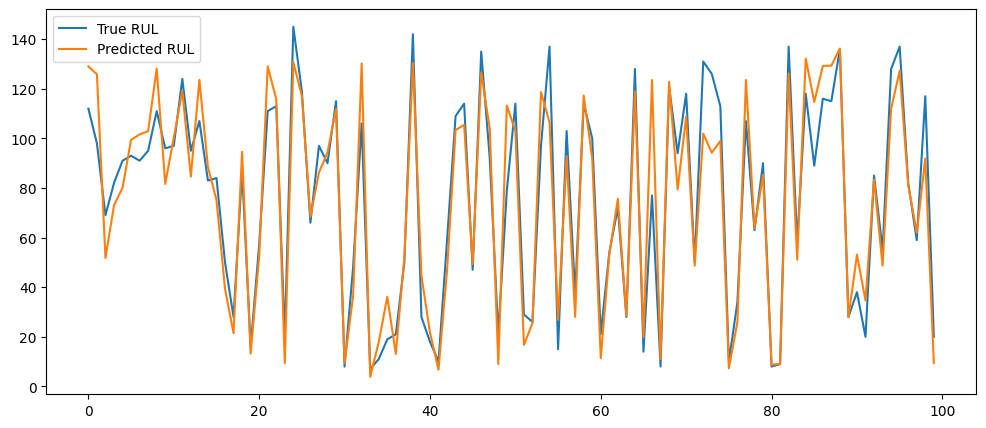

In [33]:
from utils import plot_rul

X_test_last = X_test.groupby(test_units['unit'], as_index=False).last()
y_pred = ngb_tuned.predict(X_test_last.values)
plot_rul(test_rul, y_pred)

We can see that the Predicted RUL follow closely the True RUL compared to the result of Baseline Model.

In [32]:
# Print the predicted value vs true value
pd.DataFrame({'True RUL': test_rul, 'Predicted RUL': y_pred})

,True RUL,Predicted RUL
0,112.0,129.028261
1,98.0,125.847364
2,69.0,51.760241
3,82.0,72.974155
4,91.0,80.064634
...,...,...
95,137.0,127.228299
96,82.0,81.335217
97,59.0,61.887104
98,117.0,91.919749
